# Uso de Servicios de Machine Learning de AWS
## 1. Rekognition
Es un servicio de reconocimiento de objetos en imágenes, Permite reconocer objetos o etiquetas dentro de imágenes. Funciona como un servicio desde la consola de AWS.

In [1]:
# Librerias
import glob
import boto3
import json
import csv
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io

La fotografía que se presenta a continuación se presenta dentro de la carpeta "fotos". Le pediremos al servicio AWS rekognition que nos brinde información acerca de lo que allí ve.
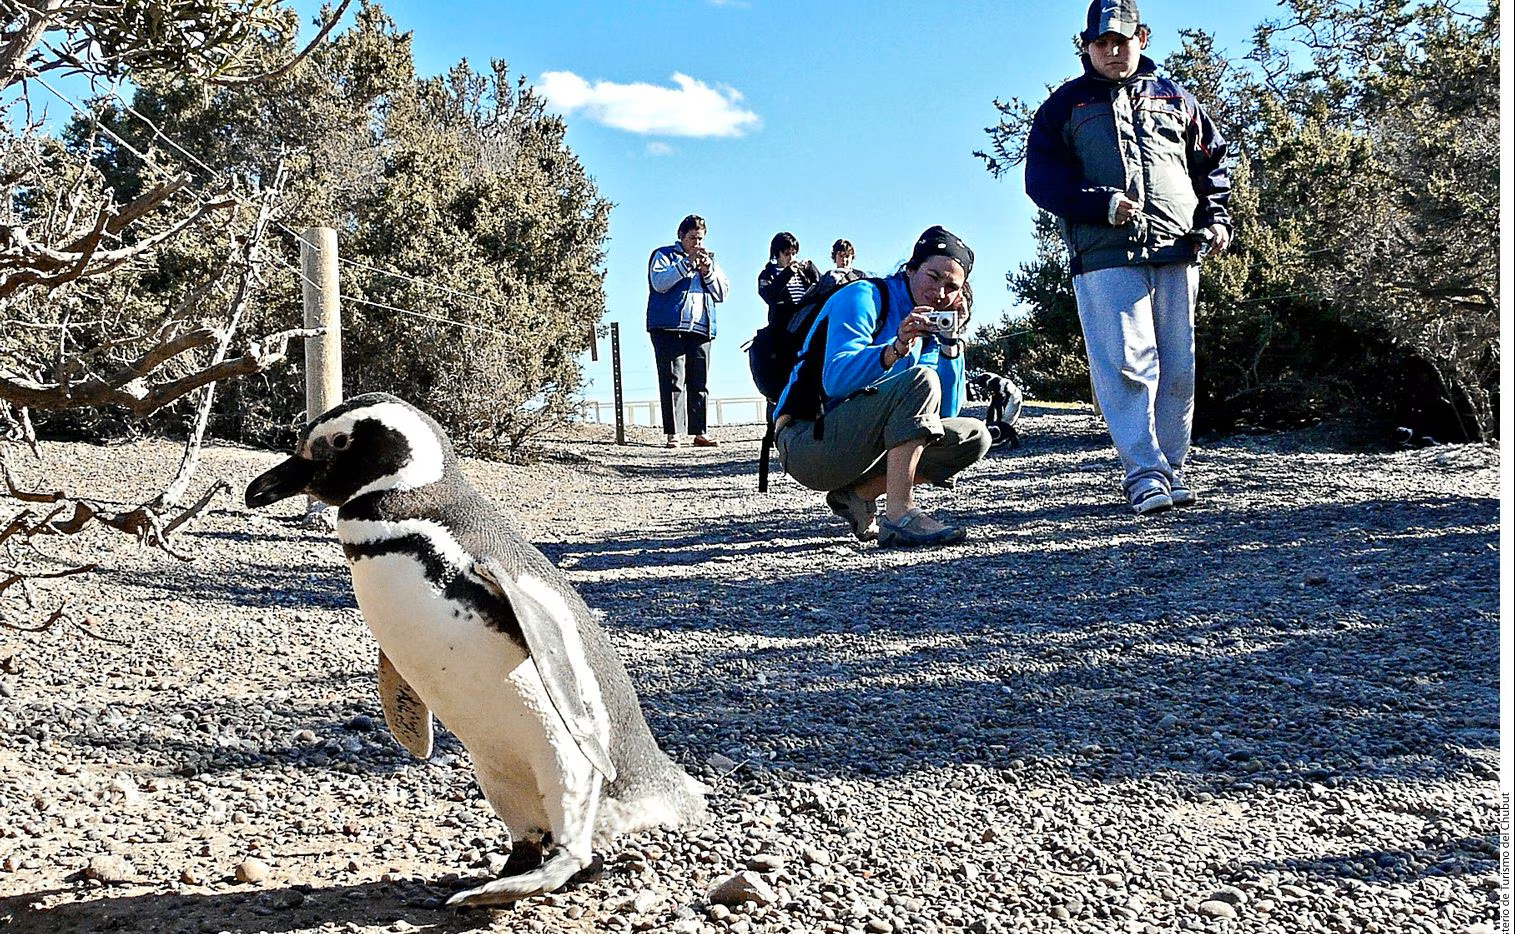

In [2]:
client = boto3.client('rekognition')
combined = []
for filename in glob.glob('fotos/*.png'):
    with open(filename, 'rb') as fd:
        response = client.detect_labels(Image={'Bytes': fd.read()})
        entry = {  "Filename": filename }
        entry["Labels"] = [
            {
                "Name": label['Name'],
                "Confidence": label['Confidence'],
                "Parents": label['Parents']
            }
            for label in response['Labels']
        ]
        combined.append(entry)

print(json.dumps(combined, indent=2))

[
  {
    "Filename": "fotos\\foto03.png",
    "Labels": [
      {
        "Name": "Animal",
        "Confidence": 99.94088745117188,
        "Parents": []
      },
      {
        "Name": "Bird",
        "Confidence": 99.94088745117188,
        "Parents": [
          {
            "Name": "Animal"
          }
        ]
      },
      {
        "Name": "Penguin",
        "Confidence": 99.94088745117188,
        "Parents": [
          {
            "Name": "Animal"
          },
          {
            "Name": "Bird"
          }
        ]
      },
      {
        "Name": "Adventure",
        "Confidence": 99.48461151123047,
        "Parents": [
          {
            "Name": "Leisure Activities"
          }
        ]
      },
      {
        "Name": "Hiking",
        "Confidence": 99.48461151123047,
        "Parents": [
          {
            "Name": "Adventure"
          },
          {
            "Name": "Leisure Activities"
          },
          {
            "Name": "Nature"
     

Usaremos el servicio "face_detection" dentro de "rekognition" para obtener info de algún rostro.

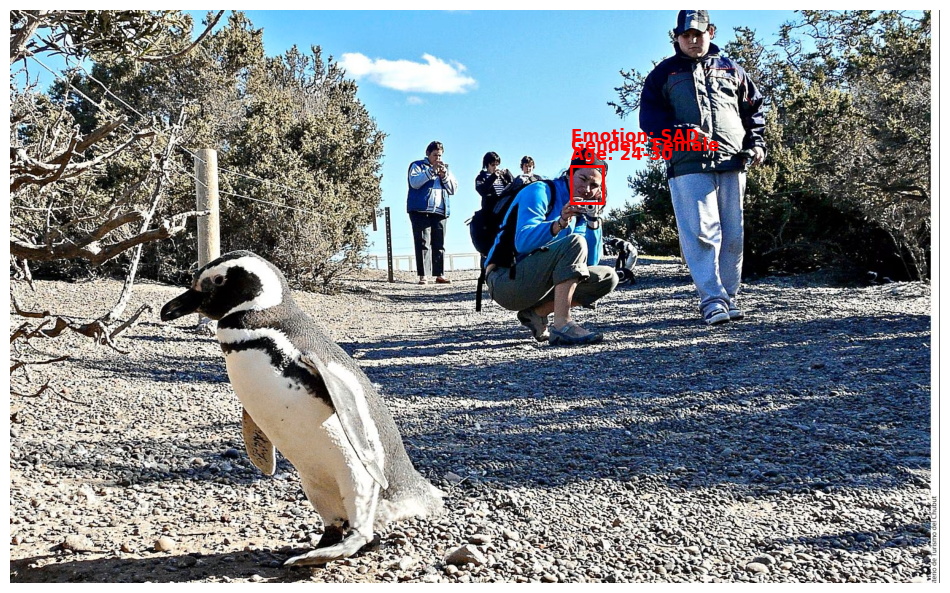

{
    "BoundingBox": {
        "Width": 0.034074295312166214,
        "Height": 0.0648517832159996,
        "Left": 0.6029065847396851,
        "Top": 0.2723863124847412
    },
    "AgeRange": {
        "Low": 24,
        "High": 30
    },
    "Smile": {
        "Value": false,
        "Confidence": 99.0737533569336
    },
    "Eyeglasses": {
        "Value": false,
        "Confidence": 97.51846313476562
    },
    "Sunglasses": {
        "Value": false,
        "Confidence": 95.36962890625
    },
    "Gender": {
        "Value": "Female",
        "Confidence": 99.84590148925781
    },
    "Beard": {
        "Value": false,
        "Confidence": 91.57504272460938
    },
    "Mustache": {
        "Value": false,
        "Confidence": 99.37223052978516
    },
    "EyesOpen": {
        "Value": true,
        "Confidence": 99.90238952636719
    },
    "MouthOpen": {
        "Value": false,
        "Confidence": 90.994140625
    },
    "Emotions": [
        {
            "Type": "SAD",
   

In [4]:
with open(filename, 'rb') as image_file:
    image_bytes = image_file.read()

# Llamar a Rekognition para detectar rostros
response = client.detect_faces(
    Image={'Bytes': image_bytes},
    Attributes=['ALL']
)

# Mostrar la imagen y los resultados de detección
image = Image.open(io.BytesIO(image_bytes))
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(image)

# Dibujar el cuadro delimitador alrededor del primer rostro detectado
if response['FaceDetails']:
    first_face_detail = response['FaceDetails'][0]
    box = first_face_detail['BoundingBox']
    left = box['Left'] * image.width
    top = box['Top'] * image.height
    width = box['Width'] * image.width
    height = box['Height'] * image.height

    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Mostrar detalles adicionales (opcional)
    age_range = first_face_detail['AgeRange']
    gender = first_face_detail['Gender']['Value']
    emotions = first_face_detail['Emotions']
    emotion = max(emotions, key=lambda x: x['Confidence'])['Type']

    plt.text(left, top - 10, f'Age: {age_range["Low"]}-{age_range["High"]}', color='red', fontsize=12, weight='bold')
    plt.text(left, top - 25, f'Gender: {gender}', color='red', fontsize=12, weight='bold')
    plt.text(left, top - 40, f'Emotion: {emotion}', color='red', fontsize=12, weight='bold')

plt.axis('off')
plt.show()

# Imprimir un JSON con los detalles del primer rostro
print(json.dumps(first_face_detail, indent=4))

## 2. Textract
Es un servicio de aprendizaje automático que analiza documentos de texto y automáticamente extrae textos y estructuras.

En este ejemplo extraeremos información desde formularios escaneados que presentan la opinión de un cliente respecto a una película recién estrenada.
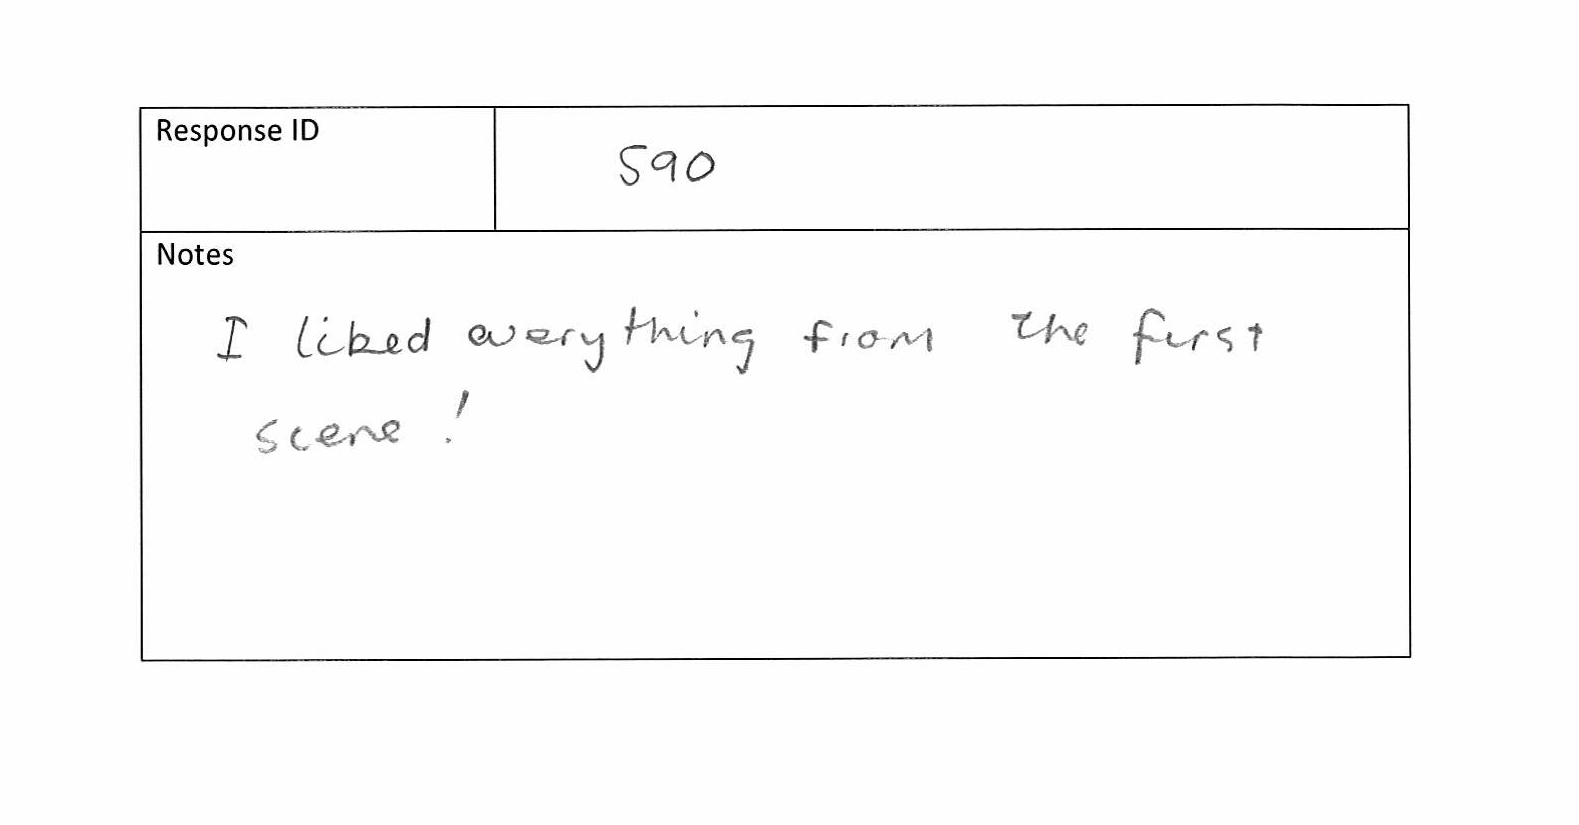 

In [8]:
# 1. Obtendremos específicamente ResponseID y Notes de la Imagen mediante QUERY
csv_array = []
client = boto3.client('textract')
for filename in glob.glob('raw_images/001.jpg'):
    csv_row = {}
    print(f"Processing: {filename}")
    with open(filename, 'rb') as fd:
        file_bytes = fd.read()

    # Procesamiento de imágenes
    response = client.analyze_document(
        Document={'Bytes': file_bytes},
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            'Queries': [
                {'Text': 'What is the response id', 'Alias': 'ResponseId'},
                {'Text': 'What are the notes?', 'Alias': 'Notes'},
            ]
        }
    )
    # Response completa a Textract
    #print(json.dumps(response, indent=4))
    for block in response["Blocks"]:
        if block["BlockType"] == "QUERY":
            query_alias = block["Query"]["Alias"]
            answer_id = next(rel["Ids"] for rel in block["Relationships"] if rel['Type'] == "ANSWER")[0]
            answer_text = next(b for b in response["Blocks"] if b["Id"] == answer_id)["Text"]
            csv_row[query_alias] = answer_text
    csv_array.append(csv_row)

# Escritura de CSV
writer = csv.DictWriter(sys.stdout, fieldnames=["ResponseId", "Notes"], dialect='excel')
writer.writeheader()
for row in csv_array:
    writer.writerow(row)


    """
    Procesamiento de la respuesta:
    ==============================
    Arriba hay dos queries que se hacen a Textract, una para obtener el ResponseId 
    y otra para obtener las Notes (son los campos de este problema). 
    * Se filtran los bloques por "QUERY".
    * ResponseID y Notes son Alias de las queries. 
    * Se consulta: query_alias=block["Query"]["Alias"] y se lo relaciona con answer_id
    * Desde answer_id se obtiene el texto de la respuesta.
    """


Processing: raw_images/001.jpg
ResponseId,Notes
590,I liked every thing from the first scene


In [10]:
# 2. Obtendremos la información directamente desde la totalidad del texto detectado, 
# sin depender de las "queries".
csv_array = []
client = boto3.client('textract')

for filename in glob.glob('raw_images/001.jpg'):
    csv_row = {}
    print(f"Processing: {filename}")
    with open(filename, 'rb') as fd:
        file_bytes = fd.read()

    # Procesamiento de imágenes sin consultas
    response = client.detect_document_text(
        Document={'Bytes': file_bytes}
    )

    # Response completa a Textract
    print(json.dumps(response, indent=4))

    # Procesamiento de la respuesta
    extracted_text = ""
    for block in response["Blocks"]:
        if block["BlockType"] == "LINE":
            extracted_text += block["Text"] + "\n"

    # Aquí puedes agregar lógica para extraer información específica del texto
    # Por ejemplo, podrías usar expresiones regulares para encontrar patrones específicos
    csv_row["ExtractedText"] = extracted_text.strip()
    csv_array.append(csv_row)

# Escritura de CSV
writer = csv.DictWriter(sys.stdout, fieldnames=["ExtractedText"], dialect='excel')
writer.writeheader()
for row in csv_array:
    writer.writerow(row)

Processing: raw_images/001.jpg
{
    "DocumentMetadata": {
        "Pages": 1
    },
    "Blocks": [
        {
            "BlockType": "PAGE",
            "Geometry": {
                "BoundingBox": {
                    "Width": 1.0,
                    "Height": 1.0,
                    "Left": 0.0,
                    "Top": 0.0
                },
                "Polygon": [
                    {
                        "X": 0.0,
                        "Y": 1.044542941031068e-07
                    },
                    {
                        "X": 1.0,
                        "Y": 0.0
                    },
                    {
                        "X": 1.0,
                        "Y": 1.0
                    },
                    {
                        "X": 0.0,
                        "Y": 1.0
                    }
                ]
            },
            "Id": "4bb7eede-cf88-492e-a796-9c8ecad8bf64",
            "Relationships": [
                {
           

## 3. Comprehend
 Comprehend es un servicio de procesamiento de lenguaje natural basado en aprendizaje profundo para obtener y descubrir perspectivas y conexiones valiosas a partir de un texto.

En este ejemplo analizaremos el contenido de un archivo csv que contiene las opiniones de varios usuarios respecto de una película recién estrenada. Cada registro contiene una opinión. Extraeremos: Lenguaje dominante (de todo el texto), y el sentimiento de cada opinión.

### 

In [18]:
# Inicio y carga
# read the movies CSV and populate the all_notes array with all the of notes
pathArchivo = os.path.join(os.getcwd(), "notes","movies.csv")
print(pathArchivo)
with open(pathArchivo, 'r') as fd:
    reader = csv.DictReader(fd, fieldnames=["ResponseId", "Notes"], dialect='excel')    
    all_notes = [{"ResponseId": row["ResponseId"], "Notes": row["Notes"]} for row in reader]

client = boto3.client('comprehend')

c:\Users\jorge.kamlofsky\Documents\AWS ML\codes\notes\movies.csv


In [20]:
# 1. Idioma:
# Para la detección de idioma, ingresamos cada nota a un str separado por saltos de línea
# y llamamos a detect_dominant_language
print("1. Detección del idioma:")
str_all_notes = "\n".join([note["Notes"] for note in all_notes])

idioma_detectado = client.detect_dominant_language(
    Text=str_all_notes
)
print("Idioma detectado: ", idioma_detectado["Languages"][0]["LanguageCode"], "- Score: ", idioma_detectado["Languages"][0]["Score"])

1. Detección del idioma:
Idioma detectado:  en - Score:  0.9926104545593262


In [21]:
# 2. Detección de sentimientos
# Se detecta sentimiento por cada nota
print("\n2. Detección de sentimientos:")
response = client.batch_detect_sentiment(
    TextList=[note["Notes"] for note in all_notes],
    LanguageCode=idioma_detectado["Languages"][0]["LanguageCode"]
)

for i, result in enumerate(response["ResultList"]):
    response_id = all_notes[i]["ResponseId"]
    note = all_notes[i]["Notes"]
    sentiment = result["Sentiment"]
    sentiment_scores = result["SentimentScore"]
    
    # Obtener el puntaje correspondiente al sentimiento detectado
    score = sentiment_scores[sentiment.capitalize()]
    
    print(f"ResponseId: {response_id} - Text: {note}")
    print(f"Sentiment: {sentiment} - Score: {score}")
    print("-" * 40)


2. Detección de sentimientos:
ResponseId: 511 - Text: I liked every thing about it!
Sentiment: POSITIVE - Score: 0.9993101358413696
----------------------------------------
ResponseId: 450 - Text: I want to watch the movie again with my daughter Was very entertained.
Sentiment: POSITIVE - Score: 0.9915886521339417
----------------------------------------
ResponseId: 590 - Text: I liked everything from the first scene!
Sentiment: POSITIVE - Score: 0.9983420372009277
----------------------------------------
ResponseId: 643 - Text: I liked the characters, and found the story very engaging
Sentiment: POSITIVE - Score: 0.9996600151062012
----------------------------------------
ResponseId: 206 - Text: the movie was great - I would recommend to all my Friends
Sentiment: POSITIVE - Score: 0.9998475313186646
----------------------------------------
ResponseId: 226 - Text: I Found the movie boring.
Sentiment: NEGATIVE - Score: 0.9976576566696167
----------------------------------------
